# Aligning signals from Music Lab mobile app trials

Experiment form of 16 trials of mixed stimuli and tasks (sitting in quiet, hearing music, talking, movement to music, select actions), on two participants and two phone positions each. 

Participant Movement recorded via three systems: 
1) Delsys motion capture system using ten markers
2) Sweetzpost respiration belt
3) Mobile phone accelerometer via MusicLab app

First task for assessing these signals is to align them to a common time frame. 

In [2]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

import activityanalysis_test as act
import respy_test as respy

## reinterpolate and filter signals for alignment

First load related files of a single trial

In [3]:
# trial timing information

# Trial to test
trial_name = "KB_T8"

# mobile app data
os.chdir('/Users/finn/Desktop/Current_Projects/Resp_Mobile_recording/Mobile_test/Data/Acc/')
filename = 'data_part2_trial_8_Stim_T8.csv'
mob = pd.read_csv(filename)

# respiration belt data
os.chdir('/Users/finn/Documents/uio-ritmo/Sweetzpot Data/1615902190449/')
#os.chdir('/Users/finn/Documents/uio-ritmo/Sweetzpot Data/1615901311927/')
filename = 'Breathing2.csv'
g = pd.read_csv(filename,',',skiprows=3,header=None)
resp = g.loc[g[1]=='force']

# motion capture recordings
os.chdir('/Users/finn/Desktop/Current_Projects/Resp_Mobile_recording/Mobile_test/Data/MC/')
filename = 'KB_Trial_08.tsv'
mocap = pd.read_csv(filename, sep='\t',skiprows=10)


In [4]:
# conditions for comparison
units = 1000 # ms
fs = 10/units # 10 Hz

cutoff = np.array([0.05,1])/units # filtering to between 1 and 0.05 hz
nyq = 0.5 * fs 
order = 2 
normal_cutoff = cutoff / nyq
b, a = butter(order, normal_cutoff, btype='bandpass', analog=False)

In [5]:
mob['Time'] = (mob['time']-mob['time'].loc[0]) # Time is time zero
df = mob
#cols = list(mob.columns)
cols = ['x', 'y', 'z', 'alpha', 'beta', 'gamma']
print(cols)

time_new = np.arange(df['Time'].iat[0],df['Time'].iat[-1],1/fs)
df_rs = pd.DataFrame()
df_rs['Time'] = time_new
df_rs = df_rs.set_index('Time')
df_rs['Time (s)'] = time_new/1000

for c in cols:
#    if not c.startswith('time') and not c.startswith('Time') :
    f = interpolate.interp1d(df.Time, df[c].values,fill_value='extrapolate')
    df_rs[c] = f(time_new)
    df_rs['filt ' + c] = filtfilt(b, a, df_rs[c])
    df_rs['diff ' + c] = respy.diffed(df_rs['filt ' + c])/np.median(np.abs(respy.diffed(respy.diffed(df_rs['filt ' + c]))))

mob_rs = df_rs.copy()

['x', 'y', 'z', 'alpha', 'beta', 'gamma']


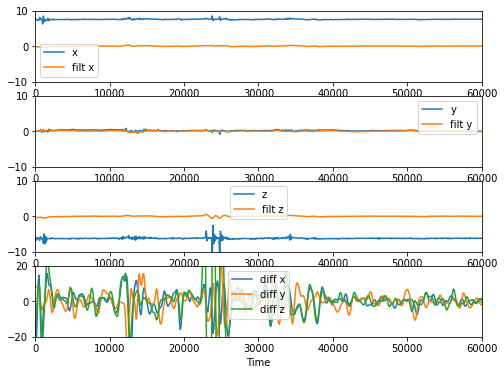

In [6]:
t_range = np.array([0,60])*units
fig = plt.figure(figsize=(8,6))
dims = ['x', 'y', 'z']# ['alpha','beta','gamma']
for i in range(len(dims)):
    d = dims[i]
    ax = plt.subplot(411 + i)
    df_rs.plot.line(y=d,ax=ax)
    df_rs.plot.line(y='filt ' + d,ax=ax)
    plt.xlim(t_range)
    plt.ylim(-10,10)

ax = plt.subplot(414)
for d in dims:
    df_rs.plot.line(y='diff ' + d,ax=ax)
    plt.xlim(t_range)
    plt.ylim(-20,20)

#plt.savefig('filtered_Mobile.png',dpi = 200)

plt.show()


In [7]:
resp = pd.DataFrame()
resp['belt'] = g.loc[g[1]=='force',3]
resp['Time'] = (g.loc[g[1]=='force',5]-g.iloc[0,5])

df = resp
#cols = list(mob.columns)
cols = ['belt']
print(cols)

time_new = np.arange(df['Time'].iat[0],df['Time'].iat[-1],1/fs)
df_rs = pd.DataFrame()
df_rs['Time'] = time_new
df_rs = df_rs.set_index('Time')
df_rs['Time (s)'] = time_new/1000

for c in cols:
#    if not c.startswith('time') and not c.startswith('Time') :
    f = interpolate.interp1d(df.Time, df[c].values,fill_value='extrapolate')
    df_rs[c] = f(time_new)
    df_rs['filt ' + c] = filtfilt(b, a, df_rs[c])
    df_rs['diff ' + c] = respy.diffed(df_rs['filt ' + c])/np.median(np.abs(respy.diffed(respy.diffed(df_rs['filt ' + c]))))

resp_rs = df_rs.copy()
resp_rs

['belt']


,Time (s),belt,filt belt,diff belt
Time,,,,
0.0,0.0,1711.0,-12.090860,-7.056418
100.0,0.1,1701.0,-28.896803,-10.295436
200.0,0.2,1697.0,-51.976977,-14.374554
300.0,0.3,1691.0,-84.586053,-18.728662
400.0,0.4,1546.0,-124.534719,-20.821372
...,...,...,...,...
274400.0,274.4,1619.0,38.234789,-0.847621
274500.0,274.5,1616.0,36.191354,-1.272001
274600.0,274.6,1613.0,33.306861,-1.646784


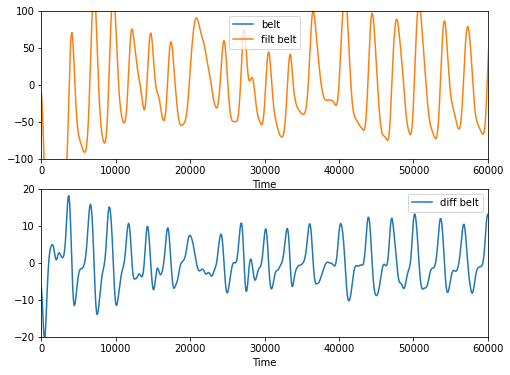

In [8]:
t_range = np.array([0,60])*units
fig = plt.figure(figsize=(8,6))
dims = ['belt']
for i in range(len(dims)):
    d = dims[i]
    ax = plt.subplot(211 + i)
    df_rs.plot.line(y=d,ax=ax)
    df_rs.plot.line(y='filt ' + d,ax=ax)
    plt.xlim(t_range)
    plt.ylim(-100,100)

ax = plt.subplot(212)
for d in dims:
    df_rs.plot.line(y='diff ' + d,ax=ax)
    plt.xlim(t_range)
    plt.ylim(-20,20)

#plt.savefig('filtered_Resp.png',dpi = 200)
plt.show()


In [9]:
mocap.Time = mocap.Time*1000

df = mocap
#cols = list(mob.columns)
cols = ['HEADT X', 'HEADT Y', 'HEADT Z', 'SHL X', 'SHL Y','SHL Z','SHR X', 'SHR Y', 'SHR Z','CH X', 'CH Y', 'CH Z']

print(cols)

time_new = np.arange(df['Time'].iat[0],df['Time'].iat[-1],1/fs)
df_rs = pd.DataFrame()
df_rs['Time'] = time_new
df_rs = df_rs.set_index('Time')
df_rs['Time (s)'] = time_new/1000

for c in cols:
#    if not c.startswith('time') and not c.startswith('Time') :
    f = interpolate.interp1d(df.Time, df[c].values,fill_value='extrapolate')
    df_rs[c] = f(time_new)
    df_rs['filt ' + c] = filtfilt(b, a, df_rs[c])
    df_rs['diff ' + c] = respy.diffed(df_rs['filt ' + c])/np.median(np.abs(respy.diffed(respy.diffed(df_rs['filt ' + c]))))

mocap_rs = df_rs.copy()
mocap_rs

['HEADT X', 'HEADT Y', 'HEADT Z', 'SHL X', 'SHL Y', 'SHL Z', 'SHR X', 'SHR Y', 'SHR Z', 'CH X', 'CH Y', 'CH Z']


,Time (s),HEADT X,filt HEADT X,diff HEADT X,HEADT Y,filt HEADT Y,diff HEADT Y,HEADT Z,filt HEADT Z,diff HEADT Z,...,diff SHR Z,CH X,filt CH X,diff CH X,CH Y,filt CH Y,diff CH Y,CH Z,filt CH Z,diff CH Z
Time,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,-212.892,-29.807170,-18.012958,-101.799,-23.178157,-5.543403,1301.644,7.759763,-8.911320,...,-3.510010,-118.594,2.310196,-9.689625,-63.628,-8.459027,-4.398327,980.444,1.917692,-0.312539
100.0,0.1,-213.419,-32.429603,-14.110209,-101.902,-24.095466,-4.494488,1301.457,7.480104,-4.501036,...,-3.308699,-119.428,1.540627,-10.049710,-63.915,-8.778617,-4.130385,980.303,1.894200,-0.549078
200.0,0.2,-214.570,-34.414821,-8.265880,-101.727,-24.821066,-2.943792,1301.221,7.384361,1.959121,...,-3.023859,-120.204,0.742982,-10.437623,-63.963,-9.078125,-3.789634,980.321,1.857810,-0.928726
300.0,0.3,-216.738,-35.128804,1.046585,-101.681,-25.171536,-0.470667,1300.705,7.643501,11.874706,...,-2.571555,-121.256,-0.087080,-10.599249,-63.966,-9.346640,-3.342799,980.376,1.792913,-1.555431
400.0,0.4,-217.038,-34.073061,12.193260,-101.665,-24.993113,2.606487,1300.855,8.374752,23.177430,...,-1.917843,-122.192,-0.909931,-9.942559,-63.986,-9.579174,-2.815916,980.318,1.688174,-2.224075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288700.0,288.7,306.515,-168.182987,139.751088,102.708,-129.984732,40.148596,1614.165,-0.313816,-420.052711,...,-250.332691,380.295,-126.763090,214.837749,125.092,-128.352770,134.994585,1286.348,-12.442068,-307.448678
288800.0,288.8,355.784,-139.638018,202.363662,120.474,-122.291626,46.027060,1609.720,-18.981399,-440.628943,...,-275.192745,427.296,-105.869906,309.261168,148.603,-116.909896,171.230109,1280.929,-30.378171,-322.920292
288900.0,288.9,410.201,-102.101678,248.266664,136.525,-113.160057,54.288990,1602.352,-37.063783,-411.127773,...,-267.976898,481.229,-78.534981,376.653319,174.141,-102.687299,204.904637,1274.807,-47.659829,-298.766572


<Figure size 576x432 with 0 Axes>

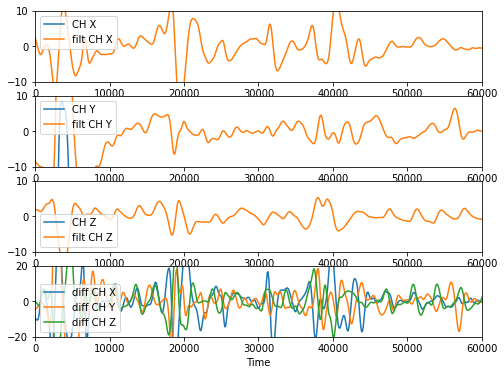

In [43]:
t_range = np.array([0,60])*units
fig = plt.figure(figsize=(8,6))
markers = ['CH']
dims = ['X','Y','Z']
for m in markers:
    fig = plt.figure(figsize=(8,6))
    for i in range(len(dims)):
        d = dims[i]
        ax = plt.subplot(411 + i)
        df_rs.plot.line(y= m + ' ' + d,ax=ax)
        df_rs.plot.line(y='filt ' + m + ' ' + d,ax=ax)
        plt.xlim(t_range)
        plt.ylim(-10,10)

    ax = plt.subplot(414)
    for d in dims:
        df_rs.plot.line(y='diff ' + m + ' ' + d,ax=ax)
        plt.xlim(t_range)
        plt.ylim(-20,20)

#plt.savefig('filtered_CH.png',dpi = 200)
plt.show()


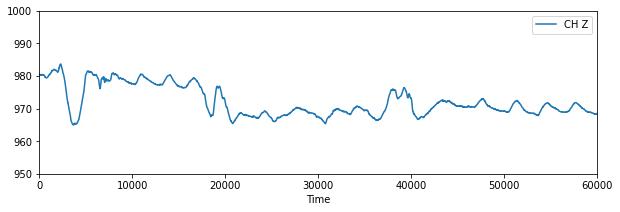

,Frame,Time,HEADT X,HEADT Y,HEADT Z,SHL X,SHL Y,SHL Z,MOBTL X,MOBTL Y,...,MOBTR X,MOBTR Y,MOBTR Z,CH X,CH Y,CH Z,HANDL X,HANDL Y,HANDL Z,Unnamed: 32
0,1,0.00,-212.892,-101.799,1301.644,-174.671,108.649,1023.986,-69.256,15.505,...,-60.428,-108.663,905.100,-118.594,-63.628,980.444,0.0,0.0,0.0,NaN
1,2,8.33,-212.956,-101.789,1301.562,-174.818,108.662,1024.009,-68.923,15.307,...,-60.237,-108.826,905.237,-118.857,-63.820,980.605,0.0,0.0,0.0,NaN
2,3,16.67,-212.994,-101.792,1301.538,-174.902,108.666,1023.992,-68.960,15.293,...,-59.804,-108.894,905.526,-118.872,-63.808,980.534,0.0,0.0,0.0,NaN
3,4,25.00,-213.014,-101.822,1301.516,-174.889,108.666,1023.983,-69.011,15.304,...,-59.875,-108.896,905.499,-118.928,-63.794,980.474,0.0,0.0,0.0,NaN
4,5,33.33,-213.056,-101.821,1301.498,-174.980,108.653,1023.962,-69.034,15.277,...,-59.831,-108.889,905.536,-118.954,-63.801,980.459,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,997,8300.00,-232.904,-97.017,1300.192,-190.320,107.757,1021.570,-82.694,16.393,...,-75.954,-107.972,903.201,-135.945,-66.179,980.248,0.0,0.0,0.0,NaN
997,998,8308.33,-232.850,-97.119,1300.169,-190.281,107.714,1021.587,-82.665,16.361,...,-75.937,-108.013,903.289,-135.918,-66.179,980.253,0.0,0.0,0.0,NaN
998,999,8316.67,-232.825,-97.220,1300.159,-190.257,107.698,1021.660,-82.724,16.343,...,-75.957,-108.040,903.255,-135.933,-66.217,980.245,0.0,0.0,0.0,NaN
999,1000,8325.00,-232.756,-97.299,1300.129,-190.257,107.675,1021.709,-82.700,16.332,...,-76.458,-107.907,903.116,-135.968,-66.317,980.297,0.0,0.0,0.0,NaN


In [44]:
mocap.plot.line(x = 'Time',y='CH Z',figsize=(10,3))
plt.xlim(0,60000)
plt.ylim(950,1000)
plt.show()
mocap.loc[:1000]

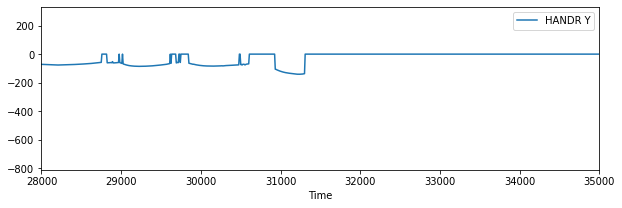

,Frame,Time,HEADT X,HEADT Y,HEADT Z,SHL X,SHL Y,SHL Z,MOBTL X,MOBTL Y,...,MOBTR X,MOBTR Y,MOBTR Z,CH X,CH Y,CH Z,HANDL X,HANDL Y,HANDL Z,Unnamed: 32
0,1,0.00,-212.892,-101.799,1301.644,-174.671,108.649,1023.986,-69.256,15.505,...,-60.428,-108.663,905.100,-118.594,-63.628,980.444,0.0,0.0,0.0,NaN
1,2,8.33,-212.956,-101.789,1301.562,-174.818,108.662,1024.009,-68.923,15.307,...,-60.237,-108.826,905.237,-118.857,-63.820,980.605,0.0,0.0,0.0,NaN
2,3,16.67,-212.994,-101.792,1301.538,-174.902,108.666,1023.992,-68.960,15.293,...,-59.804,-108.894,905.526,-118.872,-63.808,980.534,0.0,0.0,0.0,NaN
3,4,25.00,-213.014,-101.822,1301.516,-174.889,108.666,1023.983,-69.011,15.304,...,-59.875,-108.896,905.499,-118.928,-63.794,980.474,0.0,0.0,0.0,NaN
4,5,33.33,-213.056,-101.821,1301.498,-174.980,108.653,1023.962,-69.034,15.277,...,-59.831,-108.889,905.536,-118.954,-63.801,980.459,0.0,0.0,0.0,NaN
5,6,41.67,-213.108,-101.850,1301.500,-175.057,108.664,1023.937,-69.100,15.287,...,-60.349,-108.823,905.243,-118.994,-63.802,980.425,0.0,0.0,0.0,NaN
6,7,50.00,-213.093,-101.864,1301.421,-175.105,108.633,1023.893,-69.086,15.255,...,-60.256,-108.838,905.340,-118.958,-63.863,980.410,0.0,0.0,0.0,NaN
7,8,58.33,-213.136,-101.887,1301.419,-175.182,108.624,1023.911,-69.318,15.341,...,-60.178,-108.833,905.391,-118.997,-63.860,980.411,0.0,0.0,0.0,NaN
8,9,66.67,-213.191,-101.900,1301.401,-175.253,108.603,1023.909,-69.397,15.335,...,-60.248,-108.835,905.379,-119.051,-63.901,980.366,0.0,0.0,0.0,NaN
9,10,75.00,-213.235,-101.897,1301.419,-175.289,108.619,1023.889,-69.433,15.362,...,-60.578,-108.762,905.208,-119.071,-63.921,980.353,0.0,0.0,0.0,NaN


In [45]:
mocap.plot.line(x = 'Time',y='HANDR Y',figsize=(10,3))
plt.xlim(28000,35000)
#plt.ylim(950,1000)
plt.savefig('hand.png',dpi = 200)

plt.show()
mocap.loc[:10]

In [24]:
# 2892 2748
len(mob_rs)

2748

# align mocap and mobile
compare chest location data with mobile movement to see if we can align them reliably 

In [19]:
#these alignments can then be refined
M1_rs = mocap_rs.iloc[:,-9:]
M1_rs['Time (s)'] = mocap['Time']/1000
M2_rs = mob_rs
#mob_rs['sTime0'] = mob_rs.index - 3*units

Index(['CH X', 'filt CH X', 'diff CH X', 'CH Y', 'filt CH Y', 'diff CH Y',
       'CH Z', 'filt CH Z', 'diff CH Z', 'Time (s)'],
      dtype='object')
Index(['Time (s)', 'x', 'filt x', 'diff x', 'y', 'filt y', 'diff y', 'z',
       'filt z', 'diff z', 'alpha', 'filt alpha', 'diff alpha', 'beta',
       'filt beta', 'diff beta', 'gamma', 'filt gamma', 'diff gamma'],
      dtype='object')
['filt CH X', 'filt x', 15179.985535644379, 2762, 5495, 549500.0]


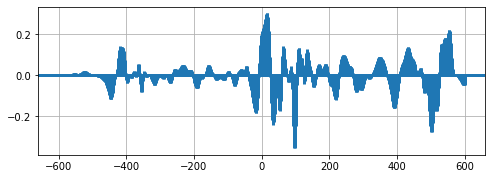

In [35]:
# for all combinations of dimensions and features, determine best cross correlation offset
cols1 = M1_rs.columns
print(cols1)
cols2 = M2_rs.columns
print(cols2)
C1 = cols1[1]
C2 = cols2[2]
length = np.min([len(M1_rs),len(M2_rs)])
# print( C1 + ' ' + C2 + ' corr r=' + str(max_r) + ' offset = ' + )
fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(211)
ax1.xcorr(M1_rs[C1].iloc[:length],M2_rs[C2].iloc[:length], usevlines=True, maxlags=600, normed=True, lw=3)
ax1.grid(True)
xc = np.correlate(M1_rs[C1].iloc[:length],M2_rs[C2].iloc[:length], "full")
print([C1, C2, np.amax(xc),np.argmax(xc,axis=0),len(xc),len(xc)/fs]) #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid


In [29]:
xc

array([   18.50006185,    30.95157899,    36.95755216, ...,
       -1065.8148778 ,  -468.65007815,  -107.64664836])

In [34]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [36]:
xcov_monthly = [crosscorr(M1_rs[C1].iloc[:length],M2_rs[C2].iloc[:length], lag=i) for i in range(12)]

In [37]:
xcov_monthly

[0.20551937463166903,
 0.2119866909497845,
 0.21681032896471283,
 0.2207929464972372,
 0.2246726511432017,
 0.22905976941127407,
 0.23438334191876234,
 0.2408581126782842,
 0.24848627998121234,
 0.25709531169636696,
 0.26638454488899344,
 0.27593930705878356]

In [39]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))


Index(['CH X', 'filt CH X', 'diff CH X', 'CH Y', 'filt CH Y', 'diff CH Y',
       'CH Z', 'filt CH Z', 'diff CH Z', 'Time (s)'],
      dtype='object')
filt y


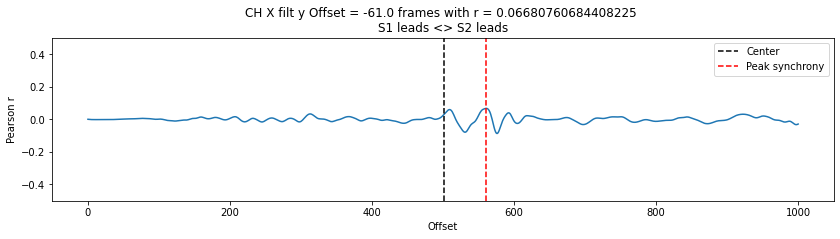

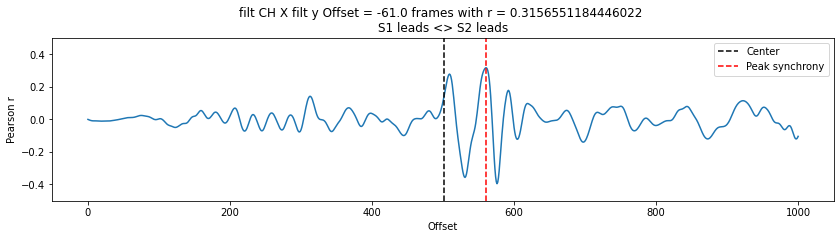

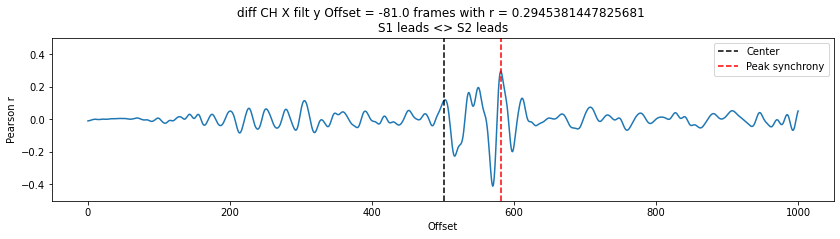

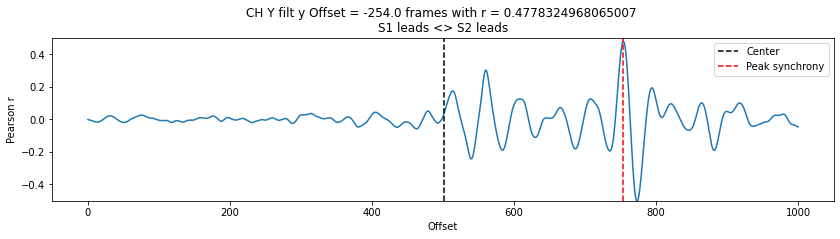

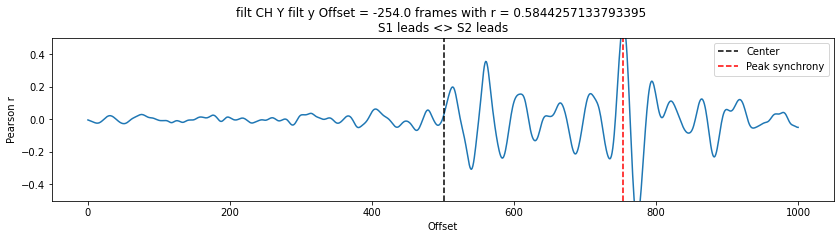

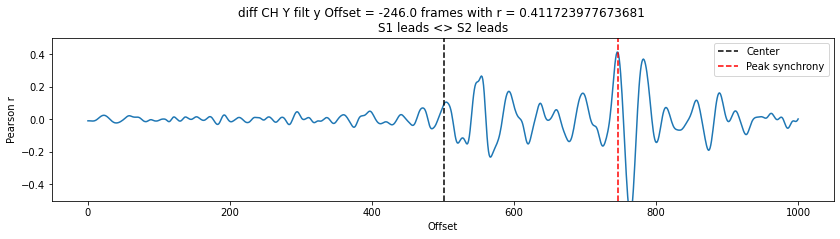

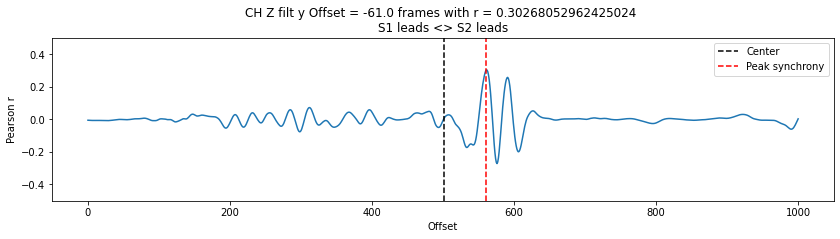

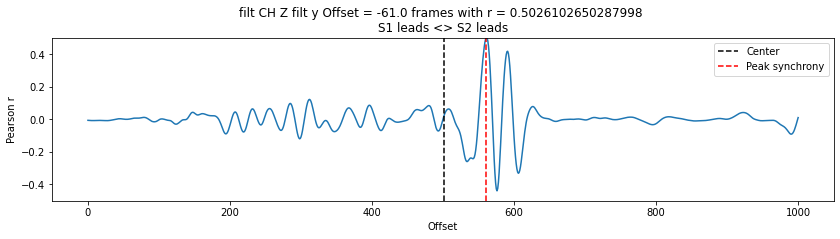

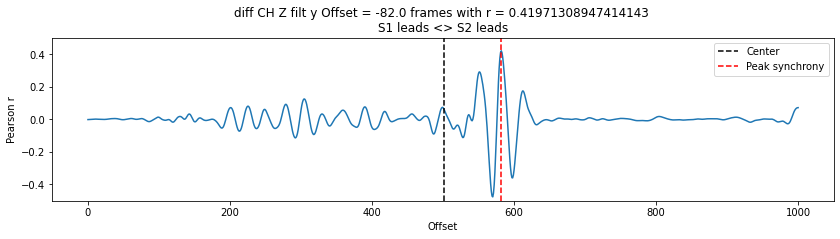

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


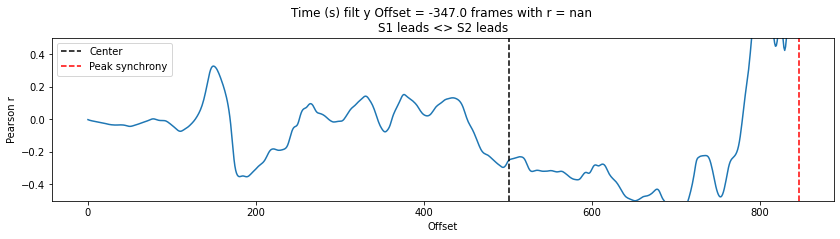

In [86]:
cols1 = M1_rs.columns
print(cols1)
cols2 = M2_rs.columns

C2 = cols2[5]
print(C2)
for C1 in cols1:
    d1 = M1_rs[C1].iloc[:length]
    d2 = M2_rs[C2].iloc[:length]
    seconds = 50
    fps = 10
    #rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
    rs = [d1.corr(d2.shift(lag)) for lag in range(-int(seconds*fps),int(seconds*fps+1))]

    offset = np.floor(len(rs)/2)-np.argmax(rs)
    r = np.max(rs)

    f,ax=plt.subplots(figsize=(14,3))
    ax.plot(rs)
    ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
    ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
    ax.set(title=f'{C1} {C2} Offset = {offset} frames with r = {r} \nS1 leads <> S2 leads',ylim=[-.5,.5], xlabel='Offset',ylabel='Pearson r')
    #ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
    #ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
    plt.legend()
    plt.show()

In [65]:
cols1 = M1_rs.columns
cols2 = M2_rs.columns
alignments = pd.DataFrame()

for C2 in cols2[1:10]:
    for C1 in cols1[:-1]:
        d1 = M1_rs[C1].iloc[:length]
        d2 = M2_rs[C2].iloc[:length]
        seconds = 50
        fps = 10
        #rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
        rs = [d1.corr(d2.shift(lag)) for lag in range(-int(seconds*fps),int(seconds*fps+1))]

        offset = np.floor(len(rs)/2)-np.argmax(rs)
        r = np.max(rs)
        alignments= alignments.append({'S1':C1,'S2':C2,'offset (s)':offset/fps,'r': r},ignore_index=True)
alignments

Index(['CH X', 'filt CH X', 'diff CH X', 'CH Y', 'filt CH Y', 'diff CH Y',
       'CH Z', 'filt CH Z', 'diff CH Z', 'Time (s)'],
      dtype='object')


,S1,S2,offset (s),r
0,CH X,x,0.1,0.132463
1,filt CH X,x,-1.5,0.271260
2,diff CH X,x,-10.3,0.291862
3,CH Y,x,-20.7,0.167190
4,filt CH Y,x,-25.5,0.221838
...,...,...,...,...
76,filt CH Y,diff z,-21.8,0.322600
77,diff CH Y,diff z,-9.7,0.260185
78,CH Z,diff z,-9.2,0.176532
79,filt CH Z,diff z,-9.2,0.277468


In [83]:
alignments.max()
np.argmax(alignments['r'])

40

In [85]:
alignments.loc[40]

S1            filt CH Y
S2               filt y
offset (s)        -25.4
r              0.584426
Name: 40, dtype: object

# Alignment testing 
Compare the signals take from the respiration belt and the mobile device and the motion capture measurements (CH and HEADT).


first to align,
Then to evaluate share in formation. 

In [47]:
#these alignments can then be refined
mocap_rs['sTime0'] = mocap_rs.index - 9*units
resp_rs['sTime0'] = resp_rs.index - 5*units
mob_rs['sTime0'] = mob_rs.index - 3*units


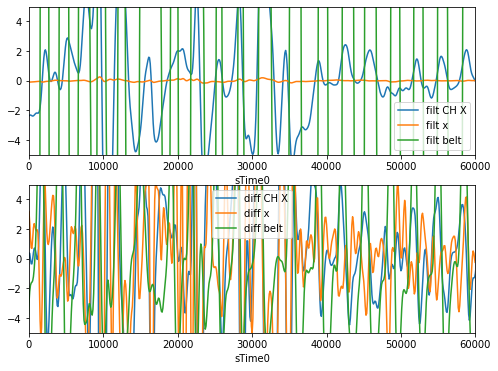

In [48]:

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(211)
tag =  'filt CH X'
mocap_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
tag =  'filt x'
mob_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
tag =  'filt belt'
resp_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
plt.xlim(0,60000)
plt.ylim(-5,5)

ax = plt.subplot(212)
tag =  'diff CH X'
mocap_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
tag =  'diff x'
mob_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
tag =  'diff belt'
resp_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
plt.xlim(0,60000)
plt.ylim(-5,5)
plt.savefig('Cross_sensor.png',dpi = 200)

plt.show()

In [ ]:

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(211)
tag =  'filt CH X'
mocap_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
tag =  'filt x'
mob_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
tag =  'filt belt'
resp_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
plt.xlim(0,60000)
plt.ylim(-5,5)

,MC,Belt,MB
MC,1.000000,-0.222243,0.003213
Belt,-0.222243,1.000000,0.052449
MB,0.003213,0.052449,1.000000


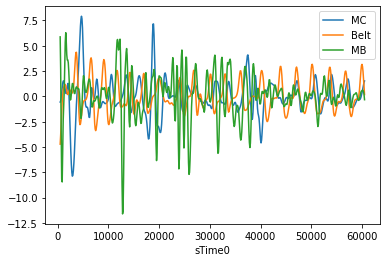

In [57]:
compSig = pd.DataFrame(index = mocap_rs['sTime0'])
compSig["MC"] = mocap_rs['diff CH Z']/np.median(np.abs(mocap_rs['diff CH Z']))
compSig["Belt"] = resp_rs['diff belt']/np.median(np.abs(resp_rs['diff belt']))
compSig["MB"] = mob_rs['diff x']/np.median(np.abs(mob_rs['diff x'])) # arbitrary scaling factor
st = resp_rs['sTime0'].iloc[5]
et = st + 60000
d_Range = compSig.loc[st:et,:]
d_Range.plot()

d_Range.corr()
#sp.stats.pearsonr(DRB['Raw'],DRB['CH Z'])[0]
# sp.stats.pearsonr(d_Range['diff belt'],d_Range['diff CH Z'])[0]


[1208.6119633495873, 1131, 2401, 240100.0, -7000.0, 60000.0]
[84487.34668348996, 1125, 2401, 240100.0, -7600.0, 160500.0]


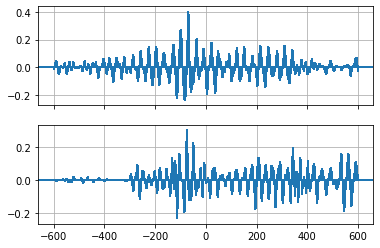

In [62]:
st = 0
et = st + 120000
mid = (st + et)/2
d_Range = compSig.loc[st:et,:]
d_Range.corr()

fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
ax1.xcorr(d_Range['Belt'],d_Range['MC'], usevlines=True, maxlags=600, normed=True, lw=2)
ax1.grid(True)
xc = np.correlate(d_Range['Belt'],d_Range['MC'], "full")
print([np.amax(xc),np.argmax(xc,axis=0),len(xc),len(xc)/fs,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid])

et = 220500.0
st = et - 120000
mid = (st + et)/2
d_Range = compSig.loc[st:et,:]
ax2.xcorr(d_Range['Belt'],d_Range['MC'], usevlines=True, maxlags=600, normed=True, lw=2)
ax2.grid(True)
xc = np.correlate(d_Range['Belt'],d_Range['MC'], "full")
print([np.amax(xc),np.argmax(xc,axis=0),len(xc),len(xc)/fs,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid])
plt.show()

<AxesSubplot:xlabel='sTime0'>

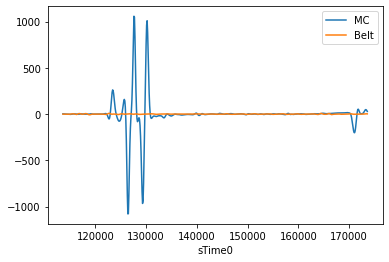

In [63]:
#these alignments can then be refined
mocap_rs['sTime0'] = mocap_rs.index - 0*units
resp_rs['sTime0'] = resp_rs.index + 113100 #0*units
#mob_rs['sTime0'] = mob_rs.index - 0*units

compSig = pd.DataFrame(index = mocap_rs['sTime0'])
compSig["MC"] = mocap_rs['diff CH Z']/np.median(np.abs(mocap_rs['diff CH Z']))
compSig["Belt"] = resp_rs['diff belt']/np.median(np.abs(resp_rs['diff belt']))
#compSig["MB"] = mob_rs['diff x']/np.median(np.abs(mob_rs['diff x'])) # arbitrary scaling factor

st = resp_rs['sTime0'].iloc[5]
et = st + 60000
d_Range = compSig.loc[st:et,:]
d_Range.plot()

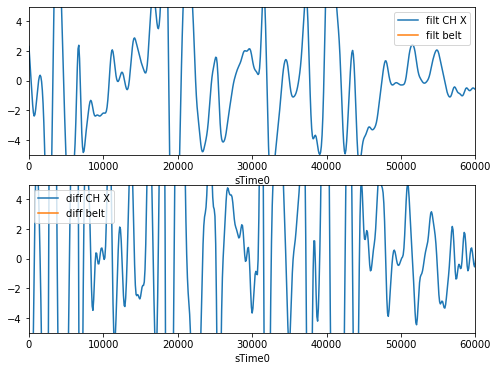

In [65]:

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(211)
tag =  'filt CH X'
mocap_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
# tag =  'filt x'
# mob_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
tag =  'filt belt'
resp_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
plt.xlim(0,60000)
plt.ylim(-5,5)

ax = plt.subplot(212)
tag =  'diff CH X'
mocap_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
# tag =  'diff x'
# mob_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
tag =  'diff belt'
resp_rs.plot.line(x = 'sTime0', y = tag,ax=ax)
plt.xlim(0,60000)
plt.ylim(-5,5)
# plt.savefig('Cross_sensor.png',dpi = 200)

plt.show()

In [ ]:
st = 0
et = st + 60000
d_Range = compSig.loc[st:et,:]
d_Range.corr()

# MC	Belt	MB
# sTime0			

fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
st = 20000
et = st + 60000
d_Range = compSig.loc[st:et,:]
d_Range.corr()
ax1.xcorr(d_Range['Belt'],d_Range['MB'], usevlines=True, maxlags=400, normed=True, lw=2)
ax1.grid(True)
xc = np.correlate(d_Range['Belt'],d_Range['MB'], "full")
print([np.amax(xc),np.argmax(xc,axis=0),len(xc),len(xc)/fs,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid])

et = 220500
st = et - 60000
mid = (st + et)/2
d_Range = compSig.loc[st:et,:]
ax2.xcorr(d_Range['Belt'],d_Range['MB'], usevlines=True, maxlags=400, normed=True, lw=2)
ax2.grid(True)
xc = np.correlate(d_Range['Belt'],d_Range['MB'], "full")
print([np.amax(xc),np.argmax(xc,axis=0),len(xc),len(xc)/fs,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid])
plt.show()

In [ ]:
st = 0
et = st + 60000
d_Range = compSig.loc[st:et,:]
d_Range.corr()

# MC	Belt	MB
# sTime0			

fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
st = 0
et = st + 60000
d_Range = compSig.loc[st:et,:]
d_Range.corr()
ax1.xcorr(d_Range['MC'],d_Range['MB'], usevlines=True, maxlags=400, normed=True, lw=2)
ax1.grid(True)
xc = np.correlate(d_Range['MC'],d_Range['MB'], "full")
print([np.amax(xc),np.argmax(xc,axis=0),len(xc),len(xc)/fs,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid])

et = 220500.0
st = et - 60000
mid = (st + et)/2
d_Range = compSig.loc[st:et,:]
ax2.xcorr(d_Range['MC'],d_Range['MB'], usevlines=True, maxlags=400, normed=True, lw=2)
ax2.grid(True)
xc = np.correlate(d_Range['MC'],d_Range['MB'], "full")
print([np.amax(xc),np.argmax(xc,axis=0),len(xc),len(xc)/fs,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid])
plt.show()

In [ ]:

df_sig = mocap['CH Z']
# interpolate to a workable comparison frame
f = interpolate.interp1d(mocap['Time'], df_sig.values,fill_value='extrapolate')
DMC = pd.DataFrame(index=resp['Time'])
DMC['CH Z'] = (f(DMC.index)-np.mean(abs(df_sig.values)))/np.mean(abs(df_sig.values))
DRB = respy.diffed(respy.respnormed(DMC))

df_sig.plot(figsize=(10,3))
#plt.xlim(0,60)
plt.ylim(950,1000)
DMC.plot(figsize=(10,3))
#plt.xlim(0,60)
plt.show()
DRB.plot(figsize=(10,3))
#plt.xlim(0,60)

# filter for comparison to resp belt 

# segments of stimuli


In [137]:
os.chdir('/Users/finn/Desktop/Current_Projects/Resp_Mobile_recording/Mobile_test/Data/')
filename = 'Trial recording - Trial Stimuli details.tsv'
stim_dets = pd.read_csv(filename,sep='\t')
filename = 'Trial recording - Qualisys_data.tsv'
rough_align = pd.read_csv(filename,sep='\t')

In [138]:
stim_dets

,Time (s),Element,Time (m:s),T1,T2,T3,T4,T5,T6,T7,T8
0,0.000,Trial number,0:00.000,1,2,3,4,5,6,7,8
1,2.136,Part 1 Synchronisation,0:02.136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20.000,taps,0:20.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23.450,Part 2 Listening task 1,0:23.450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32.000,Silence 1,0:32.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,62.000,Music 1,1:02.00,Danish quartet ex 1,Hildur Guðnadóttir/Saman/11 Torrek,Coltrane/My Favorite things/03 Summertime,Olafur Arnalds/13 Say My Name (feat. Arnór Dan),Schola Magdalena/O Gracious Light/15 Allelulia,Ben Heppner/My Secret Heart/Roses of Picardy,The Dufay Collective/Miri it is/01 Miri it is ...,Cowboy Bebop OST 3 - BLUE/14 Wo Qui Non Coin
6,92.500,Part 3: Moving tasks,1:32.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,101.000,Verbalise,1.41.00,Pets,Breakfast,music,socks,play instrument,weather,books,Horses
8,112.000,Move,1:52.0,Clapping,lean forward and back,lean forward and back,Remove phone,Text,Text,Stand stretch,Stand stretch
9,121.000,move to music,2:01.00,Standing,Standing,Seated,Standing,Seated,Standing,Seated,Standing


In [139]:
rough_align

,filename,Data type,Resp start,Mobile start,Stim,Trial stim,Participant,Trial order,Mobile loc,Music Move,Move Act
0,DS_T1_redo.qtm,Mocap,4.25,7.5,12,T1,DS,1,6,Standing,Clapping
1,DS_T2.qtm,Mocap,3.50,7.0,9,T2,DS,5,12,Standing,lean forward and back
2,DS_T3.qtm,Mocap,4.00,8.0,18,T3,DS,2,6,Seated,lean forward and back
3,DS_T4.qtm,Mocap,4.00,7.0,12,T4,DS,6,12,Standing,Remove phone
4,DS_T5.qtm,Mocap,4.00,7.0,10,T5,DS,3,6,Seated,Text
5,DS_T6.qtm,Mocap,3.00,6.0,8,T6,DS,7,12,Standing,Text
6,DS_T7.qtm,Mocap,4.00,11.0,15,T7,DS,4,6,Seated,Stand stretch
7,DS_T8.qtm,Mocap,2.50,4.5,8,T8,DS,8,12,Standing,Stand stretch
8,KB_Trial_01.qtm,Mocap,5.00,10.0,23,T1,KB,9,6,Standing,Clapping
9,KB_Trial_02.qtm,Mocap,6.00,12.0,17,T2,KB,10,6,Standing,lean forward and back


In [151]:
# trial timing information
trialno = 0 # 12
part_code = rough_align.loc[trialno,'Participant']
Trial_stim = rough_align.loc[trialno,'Trial stim']
Mob_Loc = rough_align.loc[trialno,'Mobile loc']
Move_Act = rough_align.loc[trialno,'Move Act']
Dance_Con = rough_align.loc[trialno,'Music Move']
Trial_Ord = rough_align.loc[trialno,'Trial order']

# Trial to test
trial_name = "DS_T1"

# mobile app data
os.chdir('/Users/finn/Desktop/Current_Projects/Resp_Mobile_recording/Mobile_test/Data/Acc/')
filename = 'data_part1_trial_1_Stim_T1.csv'
mob = pd.read_csv(filename)

# respiration belt data
os.chdir('/Users/finn/Documents/uio-ritmo/Sweetzpot Data/1615819583587/')
filename = 'Breathing.txt'
g = pd.read_csv(filename,' ',header=None)
resp = g.loc[g[8]=='true']

# motion capture recordings
os.chdir('/Users/finn/Desktop/Current_Projects/Resp_Mobile_recording/Mobile_test/Data/MC/')
filename = 'DS_T1_redoLabeled2.tsv'
mocap = pd.read_csv(filename, sep='\t',skiprows=10)

In [142]:
df_sTev = pd.DataFrame()

df_sTev['Element'] = stim_dets['Element']
df_sTev['qTs'] = stim_dets['Time (s)'] + rough_align['Stim'].loc[trialno]
df_sTev['qTe'] = stim_dets['Time (s)'].shift(-1,fill_value=0) + rough_align['Stim'].loc[12]
df_sTev['mTs'] = stim_dets['Time (s)'] + rough_align['Stim'].loc[trialno]-rough_align['Mobile start'].loc[trialno]
df_sTev['mTe'] = stim_dets['Time (s)'].shift(-1,fill_value=0) + rough_align['Stim'].loc[trialno]-rough_align['Mobile start'].loc[trialno]
df_sTev['rTs'] = stim_dets['Time (s)'] + rough_align['Stim'].loc[trialno]-rough_align['Resp start'].loc[trialno]
df_sTev['rTe'] = stim_dets['Time (s)'].shift(-1,fill_value=0) + rough_align['Stim'].loc[trialno]-rough_align['Resp start'].loc[trialno]
df_sTev

,Element,qTs,qTe,mTs,mTe,rTs,rTe
0,Trial number,14.000,16.136,8.000,10.136,10.000,12.136
1,Part 1 Synchronisation,16.136,34.000,10.136,28.000,12.136,30.000
2,taps,34.000,37.450,28.000,31.450,30.000,33.450
3,Part 2 Listening task 1,37.450,46.000,31.450,40.000,33.450,42.000
4,Silence 1,46.000,76.000,40.000,70.000,42.000,72.000
5,Music 1,76.000,106.500,70.000,100.500,72.000,102.500
6,Part 3: Moving tasks,106.500,115.000,100.500,109.000,102.500,111.000
7,Verbalise,115.000,126.000,109.000,120.000,111.000,122.000
8,Move,126.000,135.000,120.000,129.000,122.000,131.000
9,move to music,135.000,140.000,129.000,134.000,131.000,136.000


In [155]:
# pull out the signal segment corresponding to each element
time_cues = ['qTs','qTe']
df_QoM_seg = pd.DataFrame()
df_QoM_seg['Element'] = df_sTev['Element']
for marker in ["HEADT","SHL","SHR","CH"]:
    df_QoM_seg[marker] = 0
    for i in range(len(df_QoM_seg)-1):
        seg = mocap_rs.loc[df_sTev.loc[i,time_cues[0]]*1000:df_sTev.loc[i,time_cues[1]]*1000,[marker +' X',marker +' Y',marker +' Z']]
        a = (seg[marker + ' X'].diff()**2 +  seg[marker + ' Y'].diff()**2 +  seg[marker +' Z'].diff()**2)**0.5
        dur = df_sTev.loc[i,time_cues[1]]-df_sTev.loc[i,time_cues[0]]
        df_QoM_seg.loc[i,marker] = a.sum()/dur 
    # get the average per marker
    i = 17
    seg = mocap_rs.loc[df_sTev.loc[i,time_cues[1]]*1000:df_sTev.loc[i,time_cues[0]]*1000,[marker +' X',marker +' Y',marker +' Z']]
    a = (seg[marker + ' X'].diff()**2 +  seg[marker + ' Y'].diff()**2 +  seg[marker +' Z'].diff()**2)**0.5
    dur = df_sTev.loc[i,time_cues[0]]-df_sTev.loc[i,time_cues[1]]
    df_QoM_seg.loc[i,marker] = a.sum()/dur  
    # normalise
#    df_QoM_seg[marker]=df_QoM_seg[marker]/df_QoM_seg[marker].loc[i]

time_cues = ['mTs','mTe']
marker = 'Mobile'
df_QoM_seg[marker] = 0
for i in range(len(df_QoM_seg)-1):
    seg = mob_rs.loc[df_sTev.loc[i,time_cues[0]]*1000:df_sTev.loc[i,time_cues[1]]*1000,['x','y','z']]
    a = (seg['x'].diff()**2 +  seg['y'].diff()**2 +  seg['z'].diff()**2)**0.5
    dur = df_sTev.loc[i,time_cues[1]]-df_sTev.loc[i,time_cues[0]]
    df_QoM_seg.loc[i,marker] = a.sum()/dur 
# get the average per marker
i = 17
seg = mob_rs.loc[df_sTev.loc[i,time_cues[1]]*1000:df_sTev.loc[i,time_cues[0]]*1000,['x','y','z']]
a = (seg['x'].diff()**2 +  seg['y'].diff()**2 +  seg['z'].diff()**2)**0.5
dur = df_sTev.loc[i,time_cues[0]]-df_sTev.loc[i,time_cues[1]]
df_QoM_seg.loc[i,marker] = a.sum()/dur 
# normalise
#df_QoM_seg[marker]=df_QoM_seg[marker]/df_QoM_seg[marker].loc[i]

time_cues = ['rTs','rTe']
marker = 'Resp'
df_QoM_seg[marker] = 0
for i in range(len(df_QoM_seg)-1):
    seg = resp_rs.loc[df_sTev.loc[i,time_cues[0]]*1000:df_sTev.loc[i,time_cues[1]]*1000,'belt']
    a = seg.diff().abs()
    dur = df_sTev.loc[i,time_cues[1]]-df_sTev.loc[i,time_cues[0]]
    df_QoM_seg.loc[i,marker] = a.sum()/dur 
# get the average per marker
i = 17
seg = resp_rs.loc[df_sTev.loc[i,time_cues[1]]*1000:df_sTev.loc[i,time_cues[0]]*1000,'belt']
a = seg.diff().abs()
dur = df_sTev.loc[i,time_cues[0]]-df_sTev.loc[i,time_cues[1]]
df_QoM_seg.loc[i,marker] = a.sum()/dur    
# normalise
#df_QoM_seg[marker]=df_QoM_seg[marker]/df_QoM_seg[marker].loc[i]

df_QoM_seg.loc[i,'Element'] = 'Trial Average'

,HEADT,SHL,SHR,CH,Mobile,Resp
HEADT,1.000000,0.902993,0.902993,0.917441,0.785346,0.463364
SHL,0.902993,1.000000,0.991744,0.985552,0.801858,0.550052
SHR,0.902993,0.991744,1.000000,0.979360,0.803922,0.564499
CH,0.917441,0.985552,0.979360,1.000000,0.812178,0.523220
Mobile,0.785346,0.801858,0.803922,0.812178,1.000000,0.628483
Resp,0.463364,0.550052,0.564499,0.523220,0.628483,1.000000


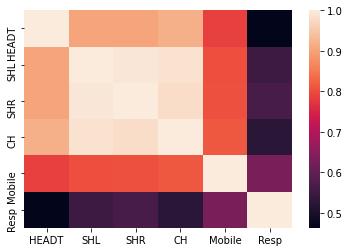

In [154]:
cs = df_QoM_seg.columns
data2 = df_QoM_seg[cs[1:]]
corr = data2.corr(method="spearman")
sns.heatmap(corr)
corr

In [147]:
df_QoM_seg['Participant'] = rough_align.loc[trialno,'Participant']
df_QoM_seg['Trial stim'] = rough_align.loc[trialno,'Trial stim']
df_QoM_seg['Mobile Loc'] = rough_align.loc[trialno,'Mobile loc']
df_QoM_seg['Move Act'] = rough_align.loc[trialno,'Move Act']
df_QoM_seg['Music Move'] = rough_align.loc[trialno,'Music Move']
df_QoM_seg['Trial order'] = rough_align.loc[trialno,'Trial order']
df_QoM_seg['Trial Name'] = trial_name

corr['Participant'] = rough_align.loc[trialno,'Participant']
corr['Trial stim'] = rough_align.loc[trialno,'Trial stim']
corr['Mobile Loc'] = rough_align.loc[trialno,'Mobile loc']
corr['Move Act'] = rough_align.loc[trialno,'Move Act']
corr['Music Move'] = rough_align.loc[trialno,'Music Move']
corr['Trial order'] = rough_align.loc[trialno,'Trial order']
corr['Trial Name'] = trial_name
corr['corrx'] = corr.index

# add segments to df_QoM_all
df_QoM_all = df_QoM_all.append(df_QoM_seg, ignore_index=True)
df_corrs_QoM = df_corrs_QoM.append(corr, ignore_index=True)



In [148]:
df_QoM_all

,Element,HEADT,SHL,SHR,CH,Mobile,Resp,Participant,Trial stim,Mobile Loc,Move Act,Music Move,Trial order,Trial Name
0,Trial number,8.393454,5.985379,5.969368,5.953702,1.355817,131.554307,KB,T5,12,Text,Seated,14,KB_T5
1,Part 1 Synchronisation,38.330335,12.278196,13.077604,10.519158,5.515492,84.079713,KB,T5,12,Text,Seated,14,KB_T5
2,taps,28.492428,7.595850,6.613284,6.301194,1.539943,99.710145,KB,T5,12,Text,Seated,14,KB_T5
3,Part 2 Listening task 1,23.051441,13.234460,11.441606,11.628677,2.534863,92.397661,KB,T5,12,Text,Seated,14,KB_T5
4,Silence 1,19.755924,4.968133,4.795192,4.885845,1.230614,94.533333,KB,T5,12,Text,Seated,14,KB_T5
5,Music 1,19.151195,5.426215,5.639335,5.291002,1.285917,105.245902,KB,T5,12,Text,Seated,14,KB_T5
6,Part 3: Moving tasks,25.063275,15.446199,13.398916,10.284865,3.735236,106.823529,KB,T5,12,Text,Seated,14,KB_T5
7,Verbalise,169.182553,143.160306,132.504110,111.528904,8.657663,200.272727,KB,T5,12,Text,Seated,14,KB_T5
8,Move,441.640260,302.570625,280.951839,666.286387,15.062630,232.111111,KB,T5,12,Text,Seated,14,KB_T5
9,move to music,106.686634,44.464880,41.249463,38.107837,5.450318,117.800000,KB,T5,12,Text,Seated,14,KB_T5


In [149]:
df_corrs_QoM

,HEADT,SHL,SHR,CH,Mobile,Resp,Participant,Trial stim,Mobile Loc,Move Act,Music Move,Trial order,Trial Name,corrx
0,1.000000,0.902993,0.902993,0.917441,0.785346,0.463364,KB,T5,12,Text,Seated,14,KB_T5,HEADT
1,0.902993,1.000000,0.991744,0.985552,0.801858,0.550052,KB,T5,12,Text,Seated,14,KB_T5,SHL
2,0.902993,0.991744,1.000000,0.979360,0.803922,0.564499,KB,T5,12,Text,Seated,14,KB_T5,SHR
3,0.917441,0.985552,0.979360,1.000000,0.812178,0.523220,KB,T5,12,Text,Seated,14,KB_T5,CH
4,0.785346,0.801858,0.803922,0.812178,1.000000,0.628483,KB,T5,12,Text,Seated,14,KB_T5,Mobile
5,0.463364,0.550052,0.564499,0.523220,0.628483,1.000000,KB,T5,12,Text,Seated,14,KB_T5,Resp


In [145]:
df_QoM_all = pd.DataFrame()
df_corrs_QoM = pd.DataFrame()